## Autocorrelations 

This notebook analysis a variety of time series related to the monthly sale count of item-shop pairs. We use this analysis to define appropriate lag features in the training data for the models 

In [64]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
import re
from itertools import product
import time
from sklearn.preprocessing import normalize



import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


#matplotlib stuff for the figures
rfont = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rfont)
plt.rcParams["legend.labelspacing"] = 0.001
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

We first perform some data processing, similary to what's being done in the EDA notebook. We get the shop cities, shop categories, item categories, item name etc. properties

In [65]:
# load data
items=pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
shops=pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
cats=pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
train=pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
test=pd.read_csv("competitive-data-science-predict-future-sales/test.csv")

In [66]:
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [67]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)



cats.loc[(cats.type_code == "Игровые") | (cats.type_code == "Аксессуары"), "category" ] = "Игры"

category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append(cat)
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

In [68]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)

/var/folders/zq/kxyb9__d7q11lb0tprf805cr0000gn/T/ipykernel_6334/1804440235.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
/var/folders/zq/kxyb9__d7q11lb0tprf805cr0000gn/T/ipykernel_6334/1804440235.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
/var/folders/zq/kxyb9__d7q11lb0tprf805cr0000gn/T/ipykernel_6334/1804440235.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  items["name1"], items["name3"] = items.item_name.str.split("(", 1).str
/var/folders/zq/kxyb9__d7q11lb0tprf805cr0000gn/T/ipykernel_6334/1804440235.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["na

We create a large matrix which includes all of our available data

In [69]:
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )

In [70]:
# add revenue to train dataframe which is then also added to matrix
train["revenue"] = train["item_cnt_day"] * train["item_price"]

group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)


test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)



matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )



matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)


### Studying the  autocorrelation for shop sales per month  
We investigate the sales history of individual shops here

In [80]:
#function which produces lag features of the total monthly sales of each shop
def lag_feature_no_itemid( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id", col ]]
        #tmp = df[["date_block_num", "shop_id", col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id",  col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id'], how='left')
    return df

In [81]:
#we get the sales history of shops over the past 34 months 

group = matrix.groupby( ['date_block_num', 'shop_id'] ).agg({"item_cnt_month" : ["sum"]})

group.columns = ["date_shop_tot_item_cnt"]
group.reset_index(inplace = True)

group = lag_feature_no_itemid(group, np.arange(0, 35, 1), ["date_shop_tot_item_cnt"] )
group = group.fillna(0)
data = group[group.date_block_num == 34] #data represents the sales history of each shop

date_shop_tot_item_cnt


In [82]:
#get multiple trends in one figure
Ids = [2, 4, 5, 6, 7, 14, 15, 16, 18, 19]
decompositions = []
for c, ids in enumerate(Ids):
    sells = np.array(data[data.shop_id == ids].T[3:]).T[0]
    sells = sells[::-1]
    sells_copy = np.copy(sells)
    sells_copy = pd.Series(data = sells_copy, name='Shop (ID={}) total monthly sales'.format(ids))
    i = np.where(sells_copy == 0)
    sells_copy.iloc[i] += 1E-20   #otherwise I cannot take logarithms...
    decom = sm.tsa.seasonal_decompose(sells_copy, period = 12, model = 'multiplicative') 
    decompositions.append(decom)
   
        


We plot the sales history, trend and seasonality of some of the shops

Text(0.5, 1.0, 'Total monthly sales of shops')

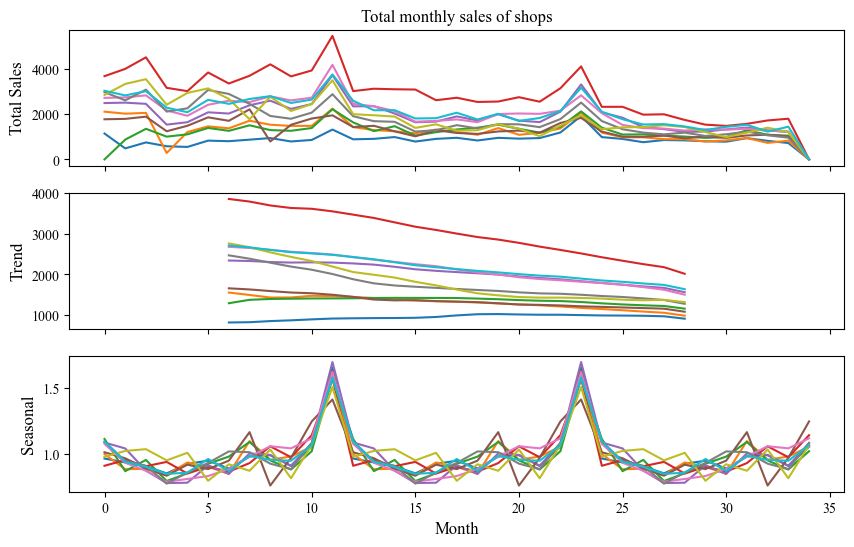

In [83]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize = (10, 6))


for c, ids in enumerate(Ids):
    decompositions[c].observed.plot(ax=axes[0], legend=False)
    decompositions[c].trend.plot(ax=axes[1], legend=False)
    decompositions[c].seasonal.plot(ax=axes[2], legend=False)

axes[0].set_ylabel('Total Sales', fontsize = 12)
axes[1].set_ylabel('Trend', fontsize = 12)
axes[2].set_ylabel('Seasonal', fontsize = 12)
axes[2].set_xlabel('Month', fontsize = 12)
axes[0].set_title('Total monthly sales of shops', fontsize = 12)
#plt.savefig('Figures/shop_trends.pdf')

Example of the autocorrelation of the sales history of a shop. The blue shaded area represents the region with a 68% confidence interval.

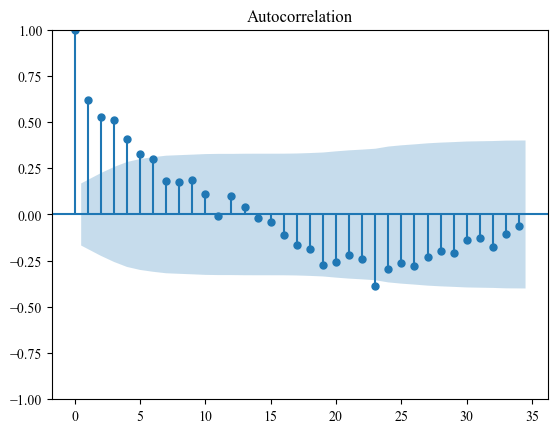

Upto a lag 5 there is still reasonable correlation, upto this lagsize the autocorrelation exceeds the         68% confidence interval


In [84]:
sells = np.array(data[data.shop_id == 6].T[3:]).T[0]
sells = sells[::-1]

plot_acf(sells, lags = 34, alpha = 0.32)
plt.show()

acf, ci = sm.tsa.acf(sells, nlags = 34, alpha = 0.32)  #alpha = 32 -> 68 % confidence interval
ci = ci[:, 1] - acf
t = acf > ci 
i = len(t[t == True]) - 1
print('Upto a lag {} there is still reasonable correlation, upto this lagsize the autocorrelation exceeds the \
        68% confidence interval'.format(i))

We now calculate the autocorrelation as a function of lag for each shop and check upto which lag size we still exceed the 68% confidence interval

In [87]:
#do this analysis quickly for all the shops

ids = data.shop_id.unique()
lag_list = []   #lag_list includes the last lag value for which there is still good correlation for a shop history 
lag_occurence = np.zeros(35)   #this counts the amount each lag size exceeds the 68% confidence interval
for j in ids:
    sells = np.array(data[data.shop_id == j].T[3:]).T[0]
    sells = sells[::-1]
    
    acf, ci = sm.tsa.acf(sells, nlags = 34, alpha = 0.32)  #alpha = 32 -> 68 % confidence interval
    ci = ci[:, 1] - acf
    t = abs(acf) > ci 
    i = np.where(t == True)[0]
    
    lag_occurence[i] += 1    
    lag_list.append(i[-1])   
    
lag_list = np.array(lag_list)    
mean = lag_list.sum() / len(ids)   
   
print('Mean maximum lag for which there is still good correlation in the data:', mean)

Mean maximum lag for which there is still good correlation in the data: 15.428571428571429


The distribution of the lag sizes exceeding the 68% confidence interval. 

Text(0.5, 1.0, 'Distribution of lag sizes for which ACF exceeds 68% confidence interval')

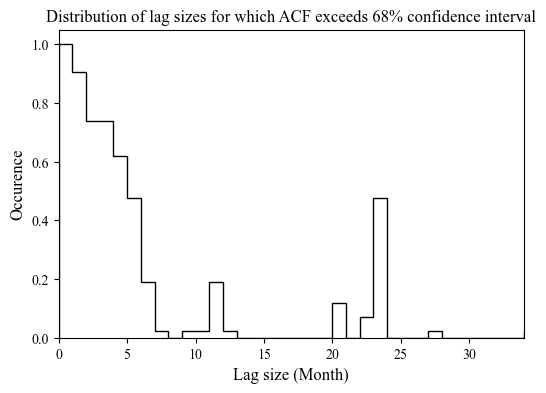

In [88]:
h = lag_occurence / len(ids)
#h = normalize([h], norm="l1")[0]
bins = np.arange(0, 36, 1)


fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.stairs(h, bins[:], color = 'black')
#plt.yscale('log')
#plt.ylim(0, 1)
ax.set_xlim(0, 34)
ax.set_ylabel('Occurence', fontsize = 12 )
ax.set_xlabel('Lag size (Month)', fontsize = 12)
ax.set_title('Distribution of lag sizes for which ACF exceeds 68% confidence interval')
#plt.savefig('Figures/ACF_tot_shop_sales.pdf')

Upto a lag size of 4, more than 50% of the shops still exhibit a high autocorrelation value. So a lag value upto 4 is useful for this timeseries. Not that at lag size 12 (1 year in the past) and 24 (2 years in the past) we also frequently have high autocorrelations. This of course makes sense!

### Studying the  autocorrelation for the monthly item sales  (item_cnt_month_lag)
We investigate the sales history of items here. Note, this is the time-series that we want to model in this competition. The analysis is analogous to that of the previous part.

In [116]:
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id", 'item_id', col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", 'item_id', col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id', 'item_id'], how='left')
    return df

In [117]:
#this cell can take a while...

group = lag_feature(matrix,  np.arange(0, 35, 1), ["item_cnt_month"] )

group = group.fillna(0)
data = group[group.date_block_num == 34]

item_cnt_month


In [118]:
items = np.array(data.T[11:]).T
items = items[::-1]
lag_list = []
lag_occurence = np.zeros(35)
nz = np.where(items.sum(axis = 1) != 0)  #we only measure the autocorrelation for items that actually were sold. Some were never sold
    
for item in items[nz]:
    acf, ci = sm.tsa.acf(item, nlags = 34, alpha = 0.32)  
    

    ci = ci[:, 1] - acf
    t = abs(acf) > ci          #above 68% confidence level
    i = np.where(t == True)[0]
    
    lag_occurence[i] += 1
    lag_list.append(i[-1])   #lag_list includes the last lag value for which there is still good correlation
    
    
lag_list = np.array(lag_list)    
mean = lag_list.sum() / items[nz].shape[0]   
   
print('Mean maximum lag for which there is still good correlation in the data:', mean)

Mean maximum lag for which there is still good correlation in the data: 5.108168305716466


Text(0.5, 1.0, 'Distribution of lag sizes for which ACF exceeds 68% confidence interval')

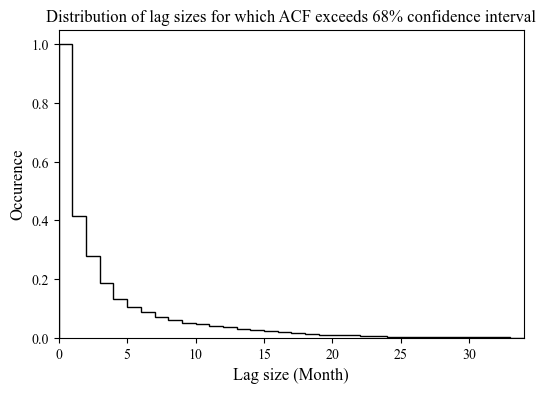

In [119]:
h = lag_occurence / items[nz].shape[0]
bins = np.arange(0, 36, 1)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.stairs(h, bins[:], color = 'black')
#plt.yscale('log')
#plt.ylim(0, 1)
ax.set_xlim(0, 34)
ax.set_ylabel('Occurence', fontsize = 12 )
ax.set_xlabel('Lag size (Month)', fontsize = 12)
ax.set_title('Distribution of lag sizes for which ACF exceeds 68% confidence interval')
#ax.set_yscale('log')
#plt.savefig('Figures/ACF_item_sales.pdf')

Upto a lag size of 3, about 20% of the items still exhibit a high autocorrelation value. So a lag value upto 3 is useful for this timeseries.

### Studying the  autocorrelation for the total monthly itemID sales  (date_item_sum_item_cnt)
We investigate the sales history of an itemID here. This means that we are summing the sales of each item with the same ID. The analysis is analogous to that of the previous part.

In [135]:
def lag_feature_no_shopid( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", 'item_id', 'item_category_id', col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", 'item_id', 'item_category_id', col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num', 'item_id', 'item_category_id'], how='left')
    return df

In [136]:
group = matrix.groupby(['date_block_num', 'item_id', 'item_category_id']).agg({'item_cnt_month': ['sum']})
group.columns = [ 'date_item_sum_item_cnt' ]
group.reset_index(inplace=True)


group = lag_feature_no_shopid(group, np.arange(0, 35, 1), ["date_item_sum_item_cnt"] )
group = group.fillna(0)
data = group[group.date_block_num == 34]


date_item_sum_item_cnt


We plot the sales history, trend and seasonality of some item IDs. Note we select items IDs which are all part of the same item category

Text(0.5, 1.0, 'Total monthly sales of different item IDs')

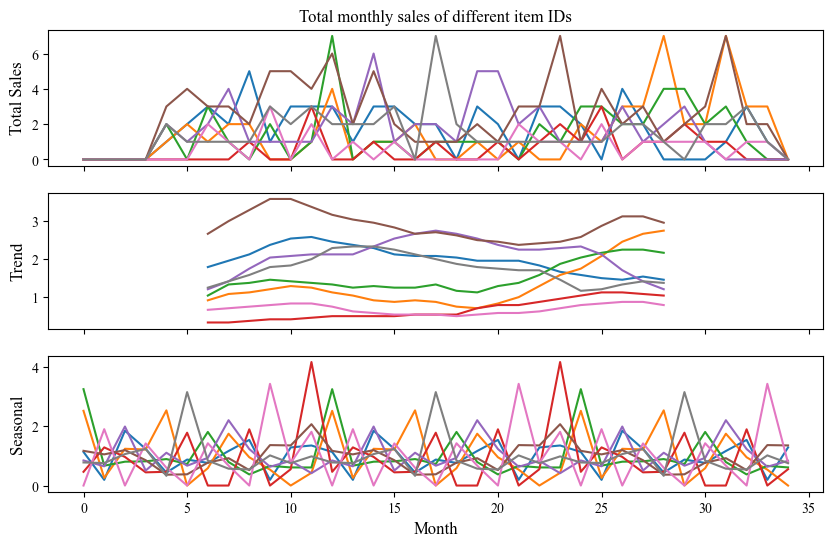

In [137]:
#get multiple trends in one figure. We select only items which are in the same item category
Ids = np.array(data.item_id.loc[data.item_category_id == 31])[:8]
decompositions = []
for c, ids in enumerate(Ids):
    sells = np.array(data[data.item_id == ids].T[4:]).T[0]
    sells = sells[::-1]
    sells_copy = np.copy(sells)
    sells_copy = pd.Series(data = sells_copy, name='Shop (ID={}) total monthly sales'.format(ids))
    i = np.where(sells_copy == 0)
    sells_copy.iloc[i] += 1E-20   #otherwise I cannot take logarithms...
    decom = sm.tsa.seasonal_decompose(sells_copy, period = 12, model = 'multiplicative') 
    decompositions.append(decom)
   
   
fig, axes = plt.subplots(3, 1, sharex=True, figsize = (10, 6))


for c, ids in enumerate(Ids):
    decompositions[c].observed.plot(ax=axes[0], legend=False)
    decompositions[c].trend.plot(ax=axes[1], legend=False)
    decompositions[c].seasonal.plot(ax=axes[2], legend=False)

axes[0].set_ylabel('Total Sales', fontsize = 12)
axes[1].set_ylabel('Trend', fontsize = 12)
axes[2].set_ylabel('Seasonal', fontsize = 12)
axes[2].set_xlabel('Month', fontsize = 12)
axes[0].set_title('Total monthly sales of different item IDs', fontsize = 12)
#plt.savefig('Figures/shop_trends.pdf')

In [138]:
items = np.array(data.T[3:]).T
items = items[::-1]  #reverse it 
lag_list = []
lag_occurence = np.zeros(35)
nz = np.where(items.sum(axis = 1) != 0)   #there's some items which have not been sold at all 
    
for item in items[nz]:
    acf, ci = sm.tsa.acf(item, nlags = 34, alpha = 0.32)  
    

    ci = ci[:, 1] - acf
    t = abs(acf) > ci          #above 68% confidence level
    i = np.where(t == True)[0]
    
    lag_occurence[i] += 1
    lag_list.append(i[-1])   #lag_list includes the last lag value for which there is still good correlation
    
    
lag_list = np.array(lag_list)    
mean = lag_list.sum() / items[nz].shape[0]   
   
print('Mean maximum lag for which there is still good correlation in the data:', mean)

Mean maximum lag for which there is still good correlation in the data: 5.85476039687566


Text(0.5, 1.0, 'Distribution of lag sizes for which ACF exceeds 68% confidence interval')

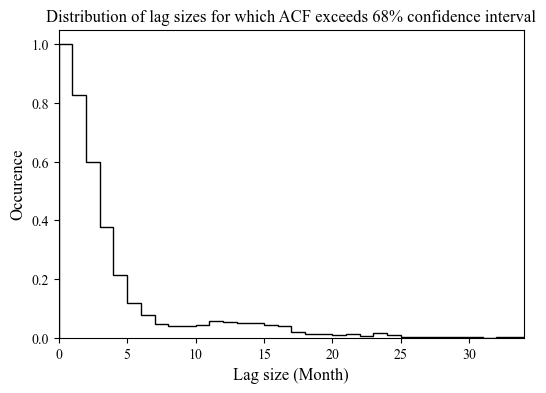

In [139]:
h = lag_occurence / items[nz].shape[0]
bins = np.arange(0, 36, 1)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.stairs(h, bins[:], color = 'black')
ax.set_xlim(0, 34)
ax.set_ylabel('Occurence', fontsize = 12 )
ax.set_xlabel('Lag size (Month)', fontsize = 12)
ax.set_title('Distribution of lag sizes for which ACF exceeds 68% confidence interval')
#plt.savefig('Figures/ACF_item_sales.pdf')

Upto a lag size of 3, about 40% of the items still exhibit a high autocorrelation value. So a lag value upto 3 is useful for this timeseries.

### Studying the autocorrelation for item prices  (delta_price)

In [130]:
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)

In [131]:
#this cell will take a while

lags = np.arange(0, 34)
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"] \
                                            .astype( np.float16 )
    matrix["delta_price_lag_" + str(i) ] = matrix["delta_price_lag_" + str(i) ].fillna(0)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )

matrix.drop(features_to_drop, axis = 1, inplace = True)


data = matrix.copy()


date_item_avg_item_price


In [133]:
#this cell will take a while

items = np.array(data.T[11:]).T
items = items[::-1]
lag_list = []
lag_occurence = np.zeros(35)
nz = np.where(items.sum(axis = 1) != 0)
    
for item in items[nz]:
    acf, ci = sm.tsa.acf(item, nlags = 34, alpha = 0.32)  
    

    ci = ci[:, 1] - acf
    t = abs(acf) > ci          #above 68% confidence level
    i = np.where(t == True)[0]
    
    lag_occurence[i] += 1
    lag_list.append(i[-1])   #lag_list includes the last lag value for which there is still good correlation
    
    
lag_list = np.array(lag_list)    
mean = lag_list.sum() / items[nz].shape[0]   
   
print('Mean maximum lag for which there is still good correlation in the data:', mean)

Mean maximum lag for which there is still good correlation in the data: 4.2919566075244395


Text(0.5, 1.0, 'Distribution of lag sizes for which ACF exceeds 68% confidence interval')

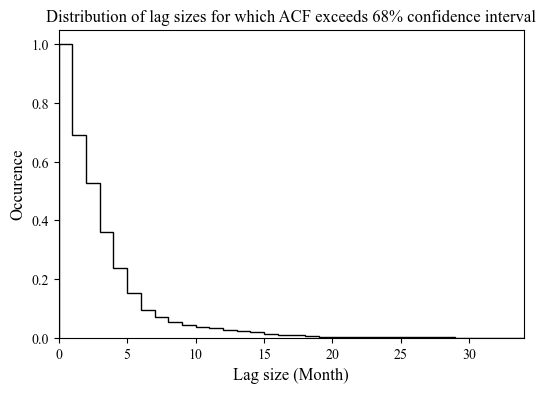

In [134]:
h = lag_occurence / items[nz].shape[0]
bins = np.arange(0, 36, 1)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.stairs(h, bins[:], color = 'black')
ax.set_xlim(0, 34)
ax.set_ylabel('Occurence', fontsize = 12 )
ax.set_xlabel('Lag size (Month)', fontsize = 12)
ax.set_title('Distribution of lag sizes for which ACF exceeds 68% confidence interval')
#plt.savefig('Figures/ACF_item_sales.pdf')

Upto a lag size of 4, about 40% of the items still exhibit a high autocorrelation value. So a lag value upto 4 is useful for this timeseries. However, in the final model we only include a lag size upto 2 as this produced better results